<a href="https://colab.research.google.com/github/rrahul2203/Deep-learning-Computer-Vision/blob/main/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Maintain the consistent performance
tf.random.set_seed(42)

# confirm GPU is available
print("Number of GPUs Available: " , len(tf.config.list_physical_devices('GPU')))

Number of GPUs Available:  1


In [2]:
# Loading the Fashion MNIST Dataset
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

4431872/4422102 [==============================] - 0s 0us/step


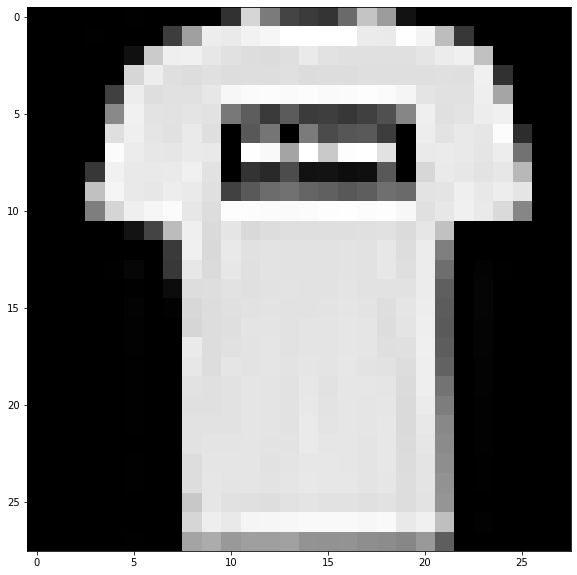

In [3]:
# Visualizing the dataset
plt.figure(figsize=(10,10))
plt.imshow(x_train[1], cmap='Greys_r')
plt.show()

In [4]:
# merge the training and testing sets
dataset = np.concatenate([x_train, x_test], axis=0)
# normalize the images from [0, 255] to [0, 1]
dataset = np.expand_dims(dataset, -1).astype("float32")/255

In [5]:
BATCH_SIZE = 64

# convolution layers work 3 channels
dataset = np.reshape(dataset, (-1,28,28,1))
# create a tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# set the batch size otherwise it reads one image at a time
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [6]:
NOISE_DIM = 150

## Define the generator model
generator  = keras.models.Sequential([
    layers.InputLayer(input_shape=(NOISE_DIM,)),
    layers.Dense(7*7*256),
    layers.Reshape(target_shape=(7,7,256)),
    layers.Conv2DTranspose(256, 3, strides=2, activation="LeakyReLU", padding="same"),
    layers.Conv2DTranspose(128, 3, strides=2, activation="LeakyReLU", padding="same"),
    layers.Conv2DTranspose(1, 3, activation="LeakyReLU", padding="same"),
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        1153      
 ranspose)                                                       
                                                        

In [7]:
## Define the discriminator model
discriminator = keras.models.Sequential([
    layers.InputLayer(input_shape=(28,28,1)),
    layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr

In [22]:
# set different learning rates for the generator and dicriminator
# we want to maintain the game balance until we arrive at the nash-equilibria
# if the discriminator gets very strong or very weak the adversial game fails
# higher learning impact the stability of the adversial game severly
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# binary classifier (real or fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# accuracy metrics 
gAccMetrics = tf.keras.metrics.BinaryAccuracy()
dAccMetrics = tf.keras.metrics.BinaryAccuracy()

In [23]:
# observe the annonation allows for efficient native tensorflow compiling
@tf.function
def trainDStep(data):
  batchsize = tf.shape(data)[0]
  # create a noise vector as generator input sampled from Gaussian Random Normal
  # As an exercise try sampling from a uniform distribution and observe the difference 
  noise = tf.random.normal(shape=(batchsize, NOISE_DIM))
  # concatenate the real and fake labells
  y_true = tf.concat(
      [
          tf.ones(batchsize, 1),
          tf.zeros(batchsize, 1)
      ],
      axis = 0
  )

  # record the calculated gradients
  with tf.GradientTape() as tape:
    ## generate the faked samples
    fake = generator(noise)
    # concatenate the real and fake datasets 
    x = tf.concat([data, fake], axis = 0)
    # see the prediction from the discriminator 
    y_pred = discriminator(x)
    # calculate the discriminator loss 
    discriminatorLoss = lossFn(y_true, y_pred)
    
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  # report accuracy
  dAccMetrics.update_state(y_true, y_pred)

  # return the loss for visulization 
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetrics.result()
  }

In [24]:
@tf.function
def trainGStep(data):
  batchsize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchsize, NOISE_DIM))
  # when training the generator we want it to maximize the probability that its
  # output is classified as real, remember the min-max game
  y_true = tf.ones(batchsize, 1)
  
  with tf.GradientTape() as tape:
    fake = generator(noise)
    y_pred = discriminator(fake)
    generatorLoss = lossFn(y_true, y_pred)
  
  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))
  gAccMetrics.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetrics.result()
  }

In [25]:
def plotImages(model):
  images = model(np.random.normal(size=(81, NOISE_DIM)))
  plt.figure(figsize=(9,9))
  for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap='Greys_r')
    plt.axis('off')
  
  plt.show()

E:1, Generator Loss:0.6931557655334473, Discrminator Loss:0.6931557655334473, Generator Acc:0.0, Discriminator Acc:50.0,
E:2, Generator Loss:0.6931557655334473, Discrminator Loss:0.6931557655334473, Generator Acc:0.0, Discriminator Acc:50.0,


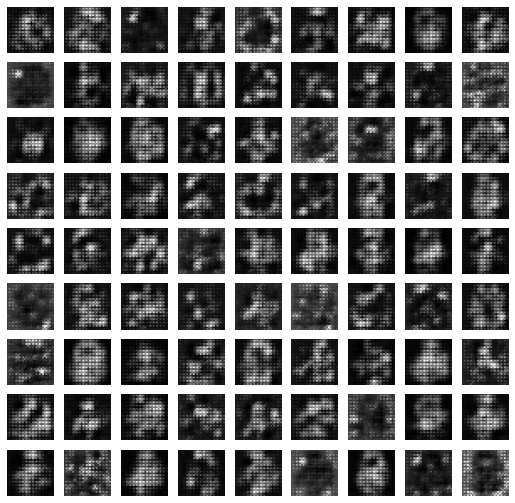

E:3, Generator Loss:0.6931557655334473, Discrminator Loss:0.6931557655334473, Generator Acc:0.0, Discriminator Acc:50.0,


In [26]:
## Train the Discriminator and Generator
EPOCHS_NUM=3
for epoch in range(EPOCHS_NUM):
  ## accumulate the loss to calculate the loss at the end of each epoch
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  count = 0
  for batch in dataset:
    ## train the discriminator --> In the orginal paper, there are mutliple 
    ## discriminator training steps per one generator training step. For 
    ## simplicity we are keeping one step of discriminator training and 
    ## generator training 
    dLoss = trainDStep(batch)
    dLossSum += dLoss["discriminator_loss"]
    dAccSum += dLoss["discriminator_accuracy"]

    ## train the generator
    gLoss = trainGStep(batch)
    gLossSum += gLoss["generator_loss"]
    gAccSum += gLoss["generator_accuracy"]

    count += 1

  ## Log the performance
  print("E:{}, Generator Loss:{}, Discrminator Loss:{}, Generator Acc:{}, Discriminator Acc:{},".format(
      epoch+1, gLossSum/count, dLossSum/count, 100* gAccSum/count, 100* dAccSum/count))

  if (epoch+1)%2==0:
    plotImages(generator)

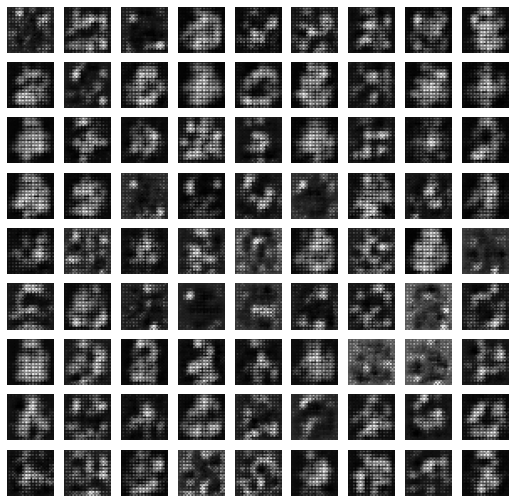

In [21]:
images = generator(np.random.normal(size=(81, NOISE_DIM)))
plt.figure(figsize=(9,9))
for i, image in enumerate(images):
  plt.subplot(9,9,i+1)
  plt.imshow(np.squeeze(image, -1), cmap='Greys_r')
  plt.axis('off')
  
plt.show()